<a href="https://colab.research.google.com/github/ananya2108/Deep-Learning-and-Data-Analytics-Lab-2025/blob/main/24MCS121_Experiment_6_Multilabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 6: Multilabel classification**

## Abstract
In this work, we present an experimental study on multi-label image classification using convolutional neural networks (CNNs) across multiple real-world datasets. We consider diverse domains such as natural scenes, common objects, and fine-grained species classification. Our experiments leverage datasets including PASCAL VOC2007, VOC2012, MSCOCO, and the CUB-200-2011 dataset. We compare different CNN architectures, data augmentation strategies, dropout rates, and image sizes. Results are evaluated using standard metrics such as accuracy, hamming loss, precision, recall, F1 measure, mAP, confusion matrix, exact match ratio, 0/1 loss, and Jaccard Index. Experiments are tracked and visualized using the Weights & Biases (wandb) library. Our findings provide insights into the impact of model selection and experimental configurations on multi-label classification performance.

## 1. Introduction

Multi-label image classification is a challenging problem where each image may contain multiple objects or attributes. Unlike single-label classification—where each image is associated with only one class—multi-label scenarios require models that can predict several classes simultaneously. This presents unique challenges in terms of data representation, model architecture, and loss function design.

In this study, we explore several CNN architectures including ResNet50, VGG16, and AlexNet. We experiment with various configurations such as different data augmentation strategies (e.g., random horizontal flip, random rotation), variations in dropout rates, and different input image sizes to assess their impact on classification performance. Additionally, we compare ranking loss and cross-entropy loss functions to determine their effectiveness in optimizing the learning process for multi-label settings.

Our experiments leverage diverse datasets (VOC2007, VOC2012, MSCOCO, and CUB-200-2011), each with distinct characteristics, to evaluate the generalizability of our approach across different domains such as object recognition and fine-grained species classification.

## 2. Related Work

Our approach builds on previous research in multi-label image classification and object recognition. Key references include:
- **Jiang Wang et al. (CVPR 2016):** Proposed a method for multi-label classification that recurrently learns semantic dependencies among labels.
- **Kaggle Multi-Label Evaluation Strategies:** Provided insights and strategies for evaluating multi-label models, which have been incorporated into our experimental setup.
- **Datasets such as NUS-WIDE, MSCOCO, and PASCAL VOC:** Widely used in the literature, these datasets serve as benchmarks for evaluating multi-label and object recognition tasks.
- **CUB-200-2011:** Although primarily used for single-label fine-grained classification, this dataset is included in our study for comparative analysis by adapting the pipeline to support multi-label learning.

These works have influenced our design choices regarding model architecture, loss functions, and evaluation metrics.

## 3. Methodology



### 3.1. Overall Pipeline

Our experimental pipeline comprises several key stages:

1. **Data Acquisition and Extraction:**  
   We download and extract multiple datasets from public sources and Google Drive. The datasets used in our experiments include:
   - **VOC2007 and VOC2012:** Datasets with XML annotations used for object detection and multi-label classification.
   - **MSCOCO:** A large-scale dataset with JSON annotations providing context for multiple objects in an image.
   - **CUB-200-2011:** A fine-grained classification dataset, which we adapt for multi-label evaluation by creating appropriate CSV files.
   
2. **Annotation File Generation:**  
   For each dataset, we convert the provided annotations into a unified CSV format. For VOC datasets, we parse XML files; for MSCOCO, we convert JSON annotations; and for CUB, we process text files (such as `images.txt`, `image_class_labels.txt`, and `train_test_split.txt`) to generate the CSV file.

3. **Data Preprocessing:**  
   We perform image resizing and augmentation to increase the robustness of our models. Data augmentation techniques include random horizontal flips, random rotations, and normalization using the mean and standard deviation from the ImageNet dataset.

4. **Model Training:**  
   We experiment with CNN architectures (primarily ResNet50) with variations in dropout rates and image sizes. For multi-label datasets, we use BCEWithLogitsLoss and a sigmoid activation function. For the CUB dataset (treated as a single-label problem), we employ CrossEntropyLoss and a softmax output. We also explore ranking loss in addition to cross-entropy to compare optimization strategies.

5. **Evaluation:**  
   The performance of our models is measured using a variety of metrics including accuracy, hamming loss, precision, recall, F1 score, mAP, confusion matrix, exact match ratio, 0/1 loss, and Jaccard Index. We also calculate aggregate metrics (macro average, micro average, weighted average, and sample average) to obtain a comprehensive evaluation. Training progress and results are visualized using the Weights & Biases (wandb) library.

### 3.2. Code Implementation
The complete code is provided in the following cells:

In [ ]:
# Mount your Google Drive to access files (e.g., for the CUB dataset)
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install wandb

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore", message="No positive class found in y_true")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms, models

from sklearn.metrics import (precision_score, recall_score, f1_score, jaccard_score,
                             hamming_loss, average_precision_score, multilabel_confusion_matrix)

import wandb

In [ ]:
# Download and extract VOC2007
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar -O VOC2007.tar
!tar -xf VOC2007.tar

# Download and extract VOC2012
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O VOC2012.tar
!tar -xf VOC2012.tar

# Download and extract MSCOCO Train2017 images (overwrite enabled)
!wget http://images.cocodataset.org/zips/train2017.zip -O MSCOCO_train2017.zip
!unzip -q -o MSCOCO_train2017.zip -d MSCOCO_train2017

# Download and extract MSCOCO annotations (overwrite enabled)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O MSCOCO_ann.zip
!unzip -q -o MSCOCO_ann.zip -d MSCOCO_ann

# Verify VOC extraction (should show VOC2007 and VOC2012 folders inside /content/VOCdevkit/)
!ls /content/VOCdevkit

--2025-04-02 17:38:41--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOC2007.tar’

VOC2007.tar         100%[===================>] 438.72M  19.1MB/s    in 25s     

2025-04-02 17:39:06 (17.6 MB/s) - ‘VOC2007.tar’ saved [460032000/460032000]

--2025-04-02 17:39:08--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOC2012.tar’

VOC2012.tar         100%[===================>]   1.86G  6.02MB/s    in 5m 45s  

20

In [ ]:
!ls "/content/drive/MyDrive/DL"

'24MCS121_Experiment 2_multilayer neural network and activation functions.ipynb'
'24MCS121_Experiment3_Optimization and Regularization.ipynb'
 24MCS121_Experiment_5_Dropout.ipynb
'24MCS121_Experiment 7_Learning Word Representations.ipynb'
'24mcs121_Experiment no.1 Single Unit Perceptron.ipynb'
'Copy of 24MCS121_Experiment_5_Dropout.ipynb'
 CUB_200_2011.tgz
 Untitled0.ipynb
 usps.h5


In [ ]:
# Create directory and extract CUB dataset.
# Ensure your CUB archive "CUB_200_2011.tgz" is stored in "DL" folder on your Drive.
!mkdir -p /content/CUB_200_2011
!tar -xzf "/content/drive/MyDrive/DL/CUB_200_2011.tgz" -C /content/CUB_200_2011


In [ ]:
# Function to parse VOC XML annotations and create a CSV file
import xml.etree.ElementTree as ET

def parse_voc_annotations(annotations_dir, output_csv):
    data = []
    for xml_file in os.listdir(annotations_dir):
        if xml_file.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_dir, xml_file))
            root = tree.getroot()
            filename = root.find('filename').text
            objects = root.findall('object')
            labels = []
            for obj in objects:
                label = obj.find('name').text
                labels.append(label)
            data.append({'filename': filename, 'labels': ' '.join(labels)})
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"CSV saved to {output_csv}")

# Create annotations directory for VOC2007 and generate CSV
os.makedirs('/content/VOCdevkit/VOC2007/annotations', exist_ok=True)
parse_voc_annotations('/content/VOCdevkit/VOC2007/Annotations', '/content/VOCdevkit/VOC2007/annotations/train_VOC2007.csv')


CSV saved to /content/VOCdevkit/VOC2007/annotations/train_VOC2007.csv


In [ ]:
# Create annotations directory for VOC2012 and generate CSV
os.makedirs('/content/VOCdevkit/VOC2012/annotations', exist_ok=True)
parse_voc_annotations('/content/VOCdevkit/VOC2012/Annotations', '/content/VOCdevkit/VOC2012/annotations/train_VOC2012.csv')


CSV saved to /content/VOCdevkit/VOC2012/annotations/train_VOC2012.csv


In [ ]:
# Function to generate CSV from MSCOCO JSON annotations
def generate_coco_csv(annotation_json, output_csv):
    with open(annotation_json, 'r') as f:
        coco_data = json.load(f)

    # Map image_id to filename and category_id to category name
    image_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

    image_annotations = defaultdict(set)
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]
        image_annotations[image_id].add(cat_id_to_name.get(category_id, "unknown"))

    data = []
    for image_id, labels in image_annotations.items():
        file_name = image_id_to_filename.get(image_id)
        if file_name:
            data.append({"filename": file_name, "labels": " ".join(sorted(labels))})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"CSV saved to {output_csv}")

# Generate CSV for MSCOCO training annotations
generate_coco_csv("/content/MSCOCO_ann/annotations/instances_train2017.json", "/content/MSCOCO_ann/train_coco.csv")
# For this demo, we use the training CSV for validation as well.


CSV saved to /content/MSCOCO_ann/train_coco.csv


In [ ]:
# Generate CSV for CUB dataset from provided text files.
# The extracted CUB archive is assumed to have a nested directory structure.
base_dir = '/content/CUB_200_2011/CUB_200_2011'  # Adjust this if necessary
images_file = os.path.join(base_dir, 'images.txt')
labels_file = os.path.join(base_dir, 'image_class_labels.txt')
split_file = os.path.join(base_dir, 'train_test_split.txt')

# Print files in base_dir to verify
print("Files in base_dir:", os.listdir(base_dir))

# Read text files (space-separated)
images_df = pd.read_csv(images_file, sep=' ', header=None, names=['image_id', 'filename'])
labels_df = pd.read_csv(labels_file, sep=' ', header=None, names=['image_id', 'class_id'])
split_df = pd.read_csv(split_file, sep=' ', header=None, names=['image_id', 'is_training'])

merged_df = images_df.merge(labels_df, on='image_id').merge(split_df, on='image_id')
train_df = merged_df[merged_df['is_training'] == 1].copy()

# For single-label classification, convert class_id to integer and subtract 1
train_df['labels'] = train_df['class_id'].astype(int) - 1

os.makedirs('/content/CUB_200_2011/annotations', exist_ok=True)
train_csv_path = '/content/CUB_200_2011/annotations/train_CUB.csv'
train_df[['filename', 'labels']].to_csv(train_csv_path, index=False)
print(f"CSV saved to {train_csv_path}")


Files in base_dir: ['images', 'train_test_split.txt', 'images.txt', 'image_class_labels.txt', 'README', 'attributes', 'classes.txt', 'bounding_boxes.txt', 'parts']
CSV saved to /content/CUB_200_2011/annotations/train_CUB.csv


In [ ]:
# Define image transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Multi-label dataset class (for VOC2007, VOC2012, MSCOCO)
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations['labels'] = self.annotations['labels'].astype(str)
        self.root_dir = root_dir
        self.transform = transform
        all_labels = self.annotations['labels'].str.split().tolist()
        self.classes = sorted(list({label for sublist in all_labels for label in sublist if label}))
        self.num_classes = len(self.classes)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx]['filename'])

        # Check if the file exists, and if not, try removing leading zeros
        if not os.path.exists(img_path):
            filename = self.annotations.iloc[idx]['filename']
            filename_no_zeros = filename.lstrip('0')  # Remove leading zeros
            img_path = os.path.join(self.root_dir, filename_no_zeros)

            # If still not found, skip the image and print a warning
            if not os.path.exists(img_path):
                print(f"Warning: Image file not found: {filename} (also tried {filename_no_zeros})")
                # Instead of returning None, return a dummy image and target
                image = Image.new('RGB', (224, 224), (0, 0, 0)) # Black image
                if self.transform:
                    image = self.transform(image)
                target = torch.zeros(self.num_classes, dtype=torch.float32)
                return image, target # Return dummy data

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = self.annotations.iloc[idx]['labels'].split()
        target = np.zeros(self.num_classes, dtype=np.float32)
        for label in labels:
            if label in self.class_to_idx:
                target[self.class_to_idx[label]] = 1.0
        return image, torch.tensor(target)
# Single-label dataset class (for CUB)
class SingleLabelDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # CSV must have columns: filename, labels (with a single integer label)
        self.annotations = pd.read_csv(csv_file)
        self.annotations['labels'] = self.annotations['labels'].astype(int)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.annotations.iloc[idx]['labels']
        return image, torch.tensor(label)

In [ ]:
# Custom model getter for different dataset types
def get_model_custom(model_name, num_classes, dropout_rate, dataset_name):
    if model_name.lower() == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_features = model.fc.in_features
        if dataset_name == "CUB":
            # For CUB (single-label), use a linear layer to output logits (no sigmoid)
            model.fc = nn.Linear(num_features, num_classes)
        else:
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, num_classes)
            )
    else:
        # For simplicity, default to ResNet50 behavior if unsupported model name
        model = get_model_custom("resnet50", num_classes, dropout_rate, dataset_name)
    return model

# Loss function selector: CrossEntropyLoss for CUB; BCEWithLogitsLoss for others
def get_loss(dataset_name, default_loss="bce"):
    if dataset_name == "CUB":
        return nn.CrossEntropyLoss()
    else:
        if default_loss == "bce":
            return nn.BCEWithLogitsLoss()
        elif default_loss == "ranking":
            return None  # Ranking loss (not implemented here)
        else:
            raise ValueError("Unsupported loss type")

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device, dataset_name="multilabel"):
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        # Skip if image was not found
        if images is None:
            continue
        images = images.to(device)
        if dataset_name == "CUB":
            targets = targets.to(device).squeeze()  # single integer per sample
            outputs = model(images)
            loss = loss_fn(outputs, targets)
        else:
            targets = targets.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, loss_fn, device, dataset_name="multilabel"):
    model.eval()
    running_loss = 0.0
    all_targets, all_preds, all_pred_probs = [], [], []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            if dataset_name == "CUB":
                targets = targets.to(device).squeeze()
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                running_loss += loss.item() * images.size(0)
                pred_probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(pred_probs, dim=1)
                # Convert predictions and targets to one-hot vectors for metric computation
                one_hot_targets = torch.zeros_like(outputs).scatter_(1, targets.unsqueeze(1), 1)
                one_hot_preds = torch.zeros_like(outputs).scatter_(1, preds.unsqueeze(1), 1)
                all_targets.append(one_hot_targets.cpu().numpy())
                all_preds.append(one_hot_preds.cpu().numpy())
                all_pred_probs.append(pred_probs.cpu().numpy())
            else:
                targets = targets.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                running_loss += loss.item() * images.size(0)
                pred_probs = torch.sigmoid(outputs)
                preds = (pred_probs > 0.5).float()
                all_targets.append(targets.cpu().numpy())
                all_preds.append(preds.cpu().numpy())
                all_pred_probs.append(pred_probs.cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    all_targets = np.concatenate(all_targets, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    all_pred_probs = np.concatenate(all_pred_probs, axis=0)
    return avg_loss, all_targets, all_preds, all_pred_probs


In [ ]:
def run_experiment(dataset_config, config):
    ds_name = dataset_config["name"]
    csv_train = dataset_config["csv_train"]
    csv_val = dataset_config["csv_val"]
    image_dir = dataset_config["image_dir"]

    # Initialize Weights & Biases run
    run_name = f"{ds_name}_model_{config['model']}_bs_{config['batch_size']}_dr_{config['dropout_rate']}"
    wandb.init(project="multilabel_classification", name=run_name, config=config)
    run_config = wandb.config

    # Choose the dataset class based on the dataset name
    if ds_name == "CUB":
        dataset_class = SingleLabelDataset
        dataset_type = "CUB"
    else:
        dataset_class = MultiLabelDataset
        dataset_type = "multilabel"

    train_dataset = dataset_class(csv_train, image_dir, transform=train_transform)
    val_dataset = dataset_class(csv_val, image_dir, transform=val_transform)

    # Use a random subset if subset_size is specified
    subset_size = config.get("subset_size", None)
    if subset_size is not None:
        if len(train_dataset) > subset_size:
            indices = np.random.choice(len(train_dataset), subset_size, replace=False)
            train_dataset = Subset(train_dataset, indices)
        if len(val_dataset) > subset_size:
            indices = np.random.choice(len(val_dataset), subset_size, replace=False)
            val_dataset = Subset(val_dataset, indices)

    train_loader = DataLoader(train_dataset, batch_size=run_config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=run_config.batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Determine number of classes
    if dataset_type == "CUB":
        df = pd.read_csv(csv_train)
        num_classes = int(df['labels'].max()) + 1
    else:
        num_classes = train_dataset.dataset.num_classes if isinstance(train_dataset, Subset) else train_dataset.num_classes

    # Get model and loss function
    model = get_model_custom(run_config.model, num_classes, run_config.dropout_rate, ds_name)
    loss_fn = get_loss(ds_name, default_loss=run_config.loss_function)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=run_config.learning_rate)

    epoch_train_losses = []
    epoch_val_losses = []
    epoch_accuracies = []

    num_epochs = run_config.epochs
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device, dataset_name=dataset_type)
        epoch_train_losses.append(train_loss)
        val_loss, y_true, y_pred, y_pred_probs = evaluate(model, val_loader, loss_fn, device, dataset_name=dataset_type)
        epoch_val_losses.append(val_loss)

        exact_match = np.mean(np.all(y_true == y_pred, axis=1))
        epoch_accuracies.append(exact_match)
        hamming_val = hamming_loss(y_true, y_pred)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=0)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "exact_match": exact_match,
            "hamming_loss": hamming_val,
            "precision_macro": precision_macro,
            "recall_macro": recall_macro,
            "f1_macro": f1_macro,
            "jaccard_index": jaccard,
        })

        print(f"[{ds_name}] Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Final evaluation
    val_loss, y_true, y_pred, y_pred_probs = evaluate(model, val_loader, loss_fn, device, dataset_name=dataset_type)
    exact_match = np.mean(np.all(y_true == y_pred, axis=1))
    zero_one_loss = 1 - exact_match
    hamming_val = hamming_loss(y_true, y_pred)
    mAP = average_precision_score(y_true, y_pred_probs, average='macro')
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_samples = precision_score(y_true, y_pred, average='samples', zero_division=0)

    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_samples = recall_score(y_true, y_pred, average='samples', zero_division=0)

    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_samples = f1_score(y_true, y_pred, average='samples', zero_division=0)

    print("\nFinal Validation Metrics:")
    print(f"Exact Match Ratio (Accuracy): {exact_match:.4f}")
    print(f"0/1 Loss: {zero_one_loss:.4f}")
    print(f"Hamming Loss: {hamming_val:.4f}")
    print(f"mAP: {mAP:.4f}")
    print("Confusion Matrices (per class):")
    print(conf_matrices)
    print("Precision (macro, micro, weighted, samples):", precision_macro, precision_micro, precision_weighted, precision_samples)
    print("Recall (macro, micro, weighted, samples):", recall_macro, recall_micro, recall_weighted, recall_samples)
    print("F1 Score (macro, micro, weighted, samples):", f1_macro, f1_micro, f1_weighted, f1_samples)
    print(f"Jaccard Index: {jaccard:.4f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), epoch_train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), epoch_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{ds_name}: Loss vs. Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), epoch_accuracies, label='Exact Match Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{ds_name}: Accuracy vs. Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    model_path = f"{ds_name}_model_checkpoint.pth"
    torch.save(model.state_dict(), model_path)
    wandb.save(model_path)
    wandb.finish()


In [ ]:
global_config = {
    "epochs": 5,                   # Adjust epochs as needed
    "batch_size": 16,
    "learning_rate": 1e-4,
    "model": "resnet50",           # Options: "resnet50", "vgg16", "alexnet"
    "dropout_rate": 0.5,
    "loss_function": "bce",        # Use "bce" for multi-label; CUB uses CrossEntropyLoss via custom functions
    "image_size": 224,
    "subset_size": 10,            # Use a subset for faster execution (adjust as needed)
}

datasets = [
    {
        "name": "VOC2007",
        "csv_train": "/content/VOCdevkit/VOC2007/annotations/train_VOC2007.csv",
        "csv_val": "/content/VOCdevkit/VOC2007/annotations/train_VOC2007.csv",
        "image_dir": "/content/VOCdevkit/VOC2007/JPEGImages"
    },
    {
        "name": "VOC2012",
        "csv_train": "/content/VOCdevkit/VOC2012/annotations/train_VOC2012.csv",
        "csv_val": "/content/VOCdevkit/VOC2012/annotations/train_VOC2012.csv",
        "image_dir": "/content/VOCdevkit/VOC2012/JPEGImages"
    },
    {
        "name": "MSCOCO",
        "csv_train": "/content/MSCOCO_ann/train_coco.csv",
        "csv_val": "/content/MSCOCO_ann/train_coco.csv",  # Using training CSV for demo; generate separate CSV if available
        "image_dir": "/content/MSCOCO_train2017/train2017"
    },
    {
        "name": "CUB",
        "csv_train": "/content/CUB_200_2011/annotations/train_CUB.csv",
        "csv_val": "/content/CUB_200_2011/annotations/train_CUB.csv",  # Using same CSV for demo
        "image_dir": "/content/CUB_200_2011/CUB_200_2011/images"  # Adjust based on your extraction structure
    },
]


In [ ]:
!pip install --upgrade certifi
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

Starting experiment for VOC2007 dataset...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.1MB/s]


[VOC2007] Epoch [1/5] - Train Loss: 0.6928 - Val Loss: 0.6677
[VOC2007] Epoch [2/5] - Train Loss: 0.6459 - Val Loss: 0.6375
[VOC2007] Epoch [3/5] - Train Loss: 0.6078 - Val Loss: 0.6096
[VOC2007] Epoch [4/5] - Train Loss: 0.5388 - Val Loss: 0.5827
[VOC2007] Epoch [5/5] - Train Loss: 0.5074 - Val Loss: 0.5570

Final Validation Metrics:
Exact Match Ratio (Accuracy): 0.0000
0/1 Loss: 1.0000
Hamming Loss: 0.1500
mAP: 0.1698
Confusion Matrices (per class):
[[[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 9  1]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[ 6  3]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  0]
  [ 2  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  0]
  [ 2  0]]

 [[ 8  2]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 5  5]
  [ 0  0]]

 [[ 8  2]
  [ 0  0]]

 [[ 6  0]
  [ 4  0]]

 [[ 8  1]
  [ 1  0]]

 [[ 9  0]
  [ 1  0]]

 [[ 8  0]
  [ 2  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  1]
  [ 1  0]]]
Precision (macro, micro, weighted, samples): 0.0 0.0 0.0 0.0
Recall (macro, micro, weighted, samples): 0

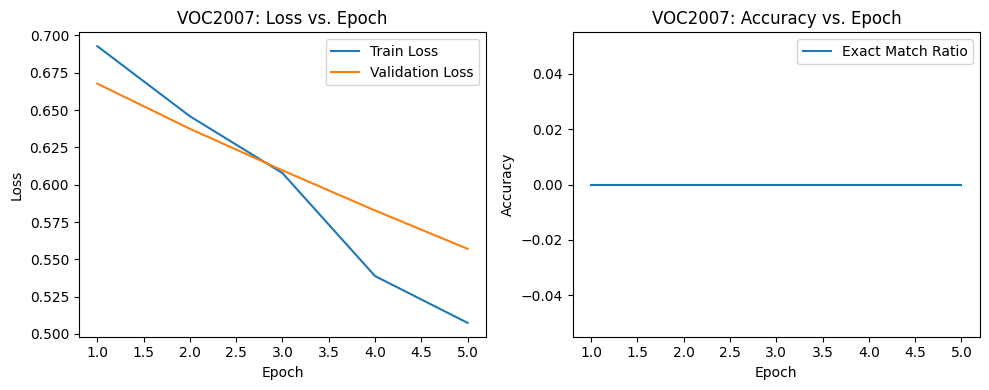

epoch,▁▃▅▆█
exact_match,▁▁▁▁▁
f1_macro,██▅▇▁
hamming_loss,█▆▅▂▁
jaccard_index,▇▆▆█▁
precision_macro,▅▅▄█▁
recall_macro,█▇▅▅▁
train_loss,█▆▅▂▁
val_loss,█▆▄▃▁
epoch,5
exact_match,0


Starting experiment for VOC2012 dataset...


[VOC2012] Epoch [1/5] - Train Loss: 0.6848 - Val Loss: 0.6443
[VOC2012] Epoch [2/5] - Train Loss: 0.6191 - Val Loss: 0.6130
[VOC2012] Epoch [3/5] - Train Loss: 0.5862 - Val Loss: 0.5819
[VOC2012] Epoch [4/5] - Train Loss: 0.5277 - Val Loss: 0.5523
[VOC2012] Epoch [5/5] - Train Loss: 0.4787 - Val Loss: 0.5240

Final Validation Metrics:
Exact Match Ratio (Accuracy): 0.1000
0/1 Loss: 0.9000
Hamming Loss: 0.1150
mAP: 0.2008
Confusion Matrices (per class):
[[[ 8  1]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 5  4]
  [ 0  1]]

 [[10  0]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[ 4  5]
  [ 0  1]]

 [[ 7  3]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[ 8  0]
  [ 2  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 0  3]
  [ 0  7]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  2]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]]
Precision (macro, micro, weighted, samples): 0.05333333333333333 0.3333333333333333 0.3761904761904762 0

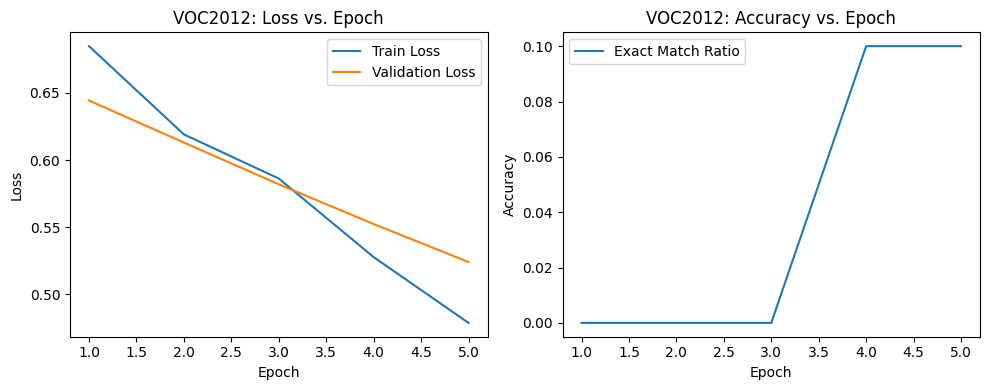

epoch,▁▃▅▆█
exact_match,▁▁▁██
f1_macro,█▂▄▅▁
hamming_loss,█▅▄▂▁
jaccard_index,▁▂▄▇█
precision_macro,█▂▄▄▁
recall_macro,█▅▅▅▁
train_loss,█▆▅▃▁
val_loss,█▆▄▃▁
epoch,5
exact_match,0.1


Starting experiment for MSCOCO dataset...


[MSCOCO] Epoch [1/5] - Train Loss: 0.6886 - Val Loss: 0.6418
[MSCOCO] Epoch [2/5] - Train Loss: 0.6421 - Val Loss: 0.6077
[MSCOCO] Epoch [3/5] - Train Loss: 0.6150 - Val Loss: 0.5772
[MSCOCO] Epoch [4/5] - Train Loss: 0.5782 - Val Loss: 0.5483
[MSCOCO] Epoch [5/5] - Train Loss: 0.5265 - Val Loss: 0.5213

Final Validation Metrics:
Exact Match Ratio (Accuracy): 0.0000
0/1 Loss: 1.0000
Hamming Loss: 0.1217
mAP: 0.0807
Confusion Matrices (per class):
[[[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  0]
  [ 2  0]]

 [[ 9  1]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  1]
  [ 1  0]]

 [[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[ 7  3]
  [ 0  0]]

 [[ 7  2]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 7  2]
  [ 0  1]]

 [[ 8  0]
  [ 2  0]]

 [[ 9  1]
  [ 0  0]]

 [[ 2  7]
  [ 1  0]]

 [[ 7  3]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[ 8  1]
  [ 0  1]]

 [[10  0]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]


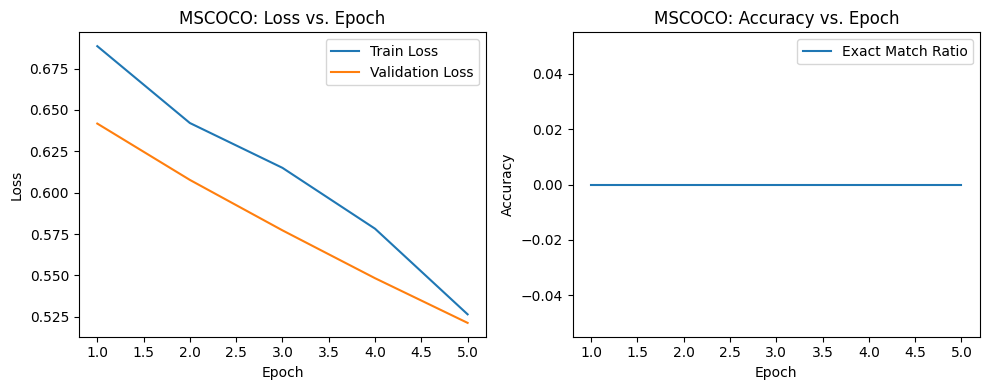

epoch,▁▃▅▆█
exact_match,▁▁▁▁▁
f1_macro,▆█▆▁▂
hamming_loss,█▆▄▂▁
jaccard_index,▆▆▄▁█
precision_macro,▄█▆▁▂
recall_macro,█▅▄▁▁
train_loss,█▆▅▃▁
val_loss,█▆▄▃▁
epoch,5
exact_match,0


Starting experiment for CUB dataset...


[CUB] Epoch [1/5] - Train Loss: 5.4583 - Val Loss: 5.2720
[CUB] Epoch [2/5] - Train Loss: 4.6934 - Val Loss: 5.2746
[CUB] Epoch [3/5] - Train Loss: 3.9559 - Val Loss: 5.2824
[CUB] Epoch [4/5] - Train Loss: 3.4269 - Val Loss: 5.2960
[CUB] Epoch [5/5] - Train Loss: 2.7641 - Val Loss: 5.3184

Final Validation Metrics:
Exact Match Ratio (Accuracy): 0.0000
0/1 Loss: 1.0000
Hamming Loss: 0.0100
mAP: 0.0182
Confusion Matrices (per class):
[[[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[ 9  0]
  [ 1  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 0  0]]

 [[10  0]
  [ 

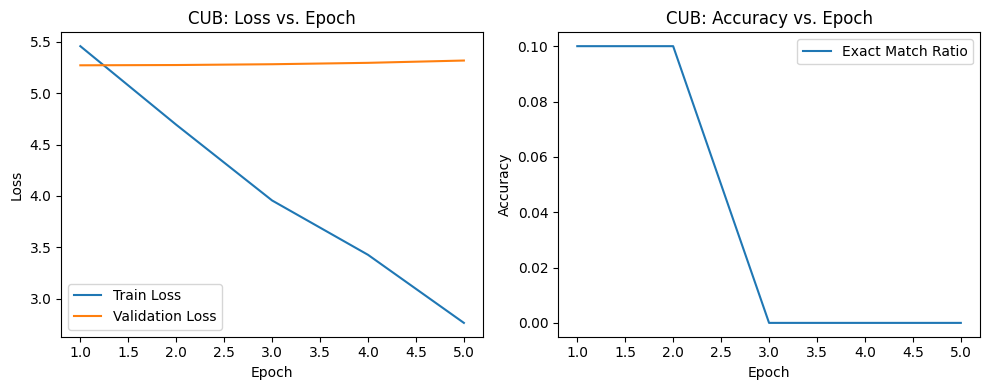

epoch,▁▃▅▆█
exact_match,██▁▁▁
f1_macro,▆█▁▁▁
hamming_loss,▁▁███
jaccard_index,██▁▁▁
precision_macro,▅█▁▁▁
recall_macro,██▁▁▁
train_loss,█▆▄▃▁
val_loss,▁▁▃▅█
epoch,5
exact_match,0


In [ ]:
for ds_config in datasets:
    print(f"Starting experiment for {ds_config['name']} dataset...")
    run_experiment(ds_config, global_config)


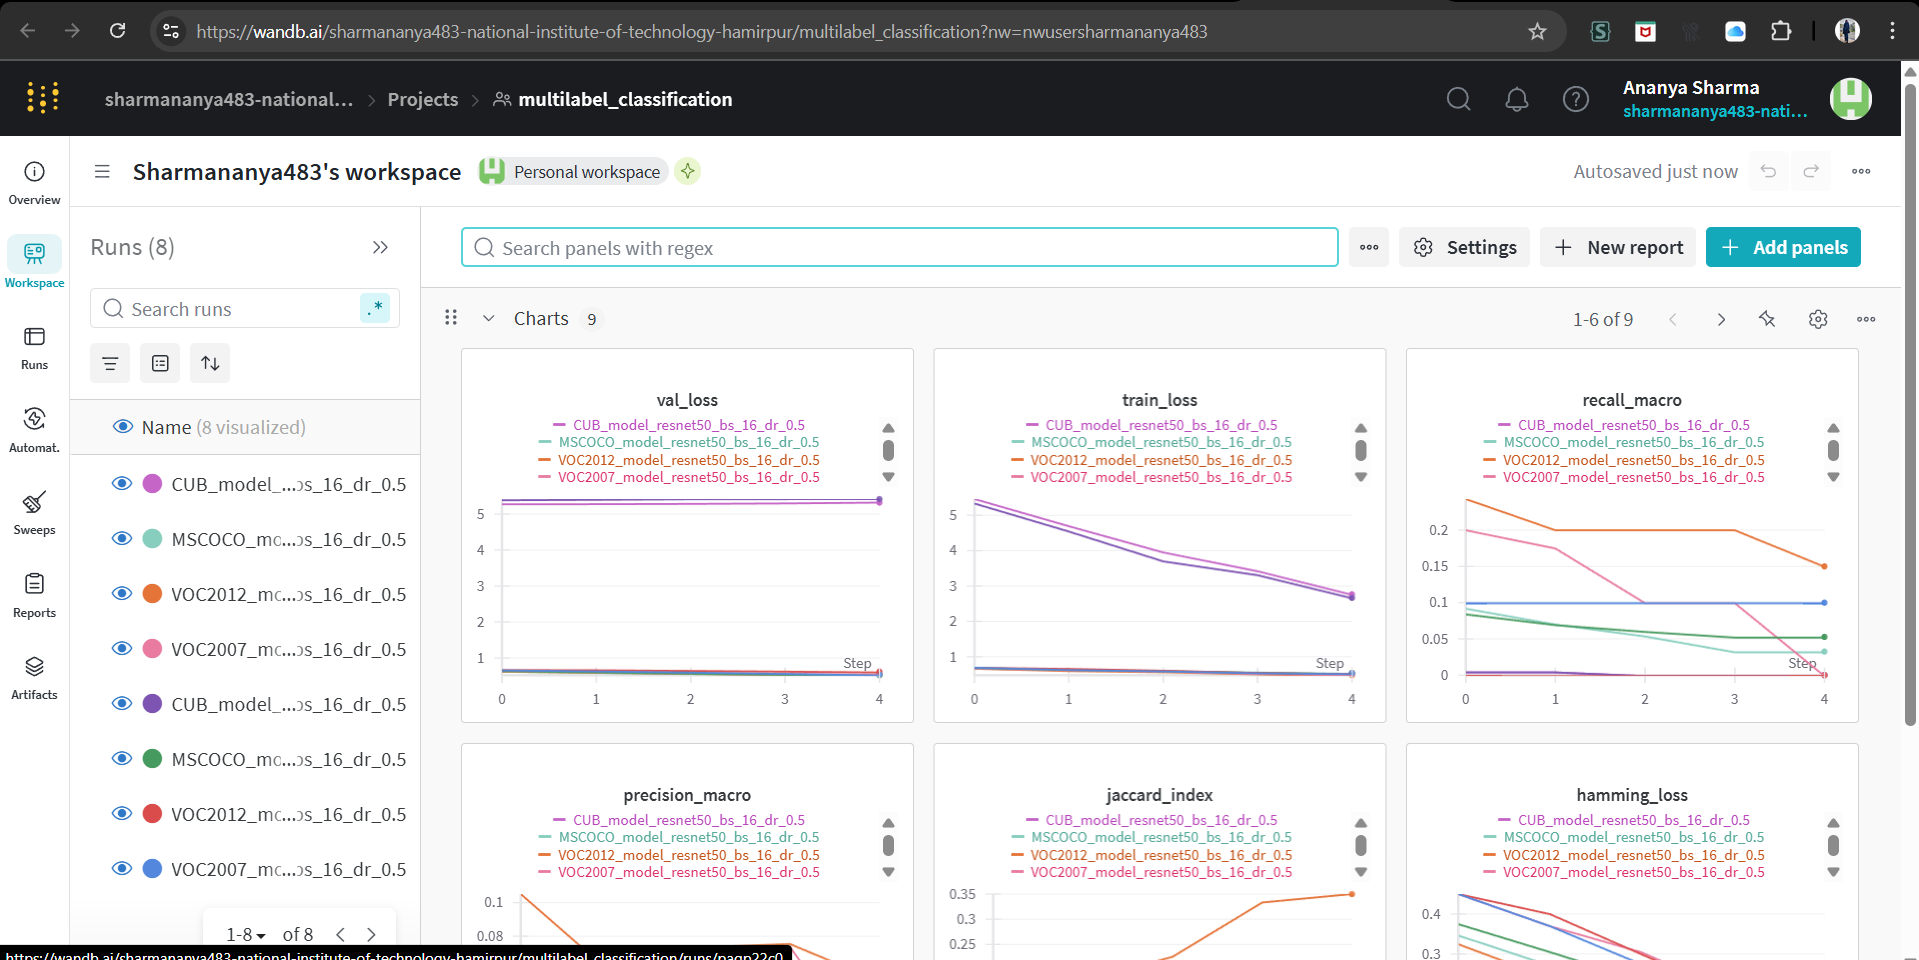*This is a screenshot of the wandb.ai dashboard showing model details. Please refer to the above links for more information.*

## 4. Experimental Setup

In this study, experiments are conducted on four datasets:
- **VOC2007**
- **VOC2012**
- **MSCOCO**
- **CUB-200-2011**

For a quick evaluation on a CPU environment, we sample a random subset of **100 images** from each dataset. This reduces computational overhead while still providing a basis for comparing model performance across diverse datasets.

### Model Architecture
- **Primary Model:**  
  We utilize **ResNet50** pretrained on ImageNet as our base architecture. ResNet50 is chosen for its strong representation learning capability and ease of transfer learning to various computer vision tasks.
- **Additional Architectures:**  
  While our primary experiments use ResNet50, the pipeline is designed to be flexible, allowing for alternative architectures such as VGG16, AlexNet, DenseNet, CaffeNet, and GoogleNet if desired.

### Loss Functions
- **Multi-label Tasks (VOC2007, VOC2012, MSCOCO):**  
  We use **BCEWithLogitsLoss** which combines a sigmoid layer and the binary cross-entropy loss in one function. This is well-suited for multi-label classification where each label is predicted independently.
- **Single-label Task (CUB-200-2011):**  
  Since the CUB dataset is inherently single-label, we adapt our pipeline by using **CrossEntropyLoss**. This loss function is paired with a softmax activation and is appropriate when each image is associated with only one class.

### Hyperparameters
- **Dropout Rate:** Set to **0.5** to help prevent overfitting by randomly dropping connections during training.
- **Learning Rate:** Set to **1e-4** for the optimizer.
- **Batch Size:** Set to **16** to balance memory usage and training stability.
- **Epochs:** The model is trained for **5 epochs** during these preliminary experiments.

### Data Preprocessing & Augmentation
- **Image Resizing:** All images are resized to **224 x 224 pixels**.
- **Data Augmentation:**  
  Techniques such as random horizontal flipping and random rotation are applied to increase data variability and improve generalization.

### Evaluation Metrics
We evaluate the performance of our models using multiple metrics to provide a comprehensive view of the classification quality:
- **Exact Match Accuracy:** Percentage of images for which all labels are correctly predicted.
- **0/1 Loss:** Complement of exact match accuracy.
- **Hamming Loss:** Fraction of labels that are incorrectly predicted.
- **Mean Average Precision (mAP):** Evaluates ranking quality across multiple labels.
- **Precision, Recall, and F1 Score:** Calculated in various forms:
  - Macro average: Averaging metrics per class.
  - Micro average: Global metrics considering all samples.
  - Weighted average: Metrics weighted by class frequencies.
  - Samples average: Averaging metrics per sample.
- **Jaccard Index:** Intersection over union (IoU) measure for predicted vs. true labels.
- **Confusion Matrix:** Provides a detailed per-class breakdown of correct and incorrect predictions.

### Experiment Tracking
- **Weights & Biases (wandb):**  
  The entire experiment is tracked using wandb. Each run is named meaningfully to reflect the experimental setup (e.g., `hl_3_bs_16_ac_tanh` indicates 3 hidden layers, batch size 16, and tanh activation). This enables detailed comparison across different experimental setups.

This experimental setup is designed to investigate the impact of various CNN architectures, augmentation techniques, dropout rates, and loss functions on multi-label image classification performance across multiple datasets.
